In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import json
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os

Using TensorFlow backend.
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

In [40]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http', 'bully', 'bullying', 'rt', 'httplink', 'mkr'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
df = pd.read_csv('../text_twitter_type_raw.csv')
print(df.Type.unique())
types=['sexism', 'racism']

df = df.loc[df['Type'].isin(types)]
print(df.Type.unique())
print(df)


['none' 'sexism' 'racism']
['sexism' 'racism']
                                                    Text    Type     Label
2      RT @username Call me sexist, but when I go to ...  sexism  positive
3      @username Wrong, ISIS follows the example of M...  racism  positive
6      RT @username @username nooo not sexist but mos...  sexism  positive
9      RT @username There's something wrong when a gi...  sexism  positive
11     @username @username @username @username A good...  racism  positive
...                                                  ...     ...       ...
16832  RT @username Just don't find Woman comedians f...  sexism  positive
16834  RT @username I'm not sexist but I hate all fem...  sexism  positive
16836  @username Yes, all that Islam is making ISIS s...  racism  positive
16841  yeah so annoying how they're doing their jobs ...  sexism  positive
16844  @username An enemy of @username is good enough...  sexism  positive

[5347 rows x 3 columns]


In [41]:
"""remove_rt = lambda x: re.sub('RT @\w+: ', "", x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",x)
df.Text = df.Text.map(remove_rt).map(rt)

print(df.Text)"""

# Convert to list
data = df.Text.values.tolist()

data = [re.sub('RT @\w+: ', "",sent) for sent in data]

#remove links
data = [re.sub(r"http\S+", "", sent) for sent in data]


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['RT Call me sexist, but when I go to an auto place, Id rather talk to a guy']


In [42]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['rt', 'call', 'me', 'sexist', 'but', 'when', 'go', 'to', 'an', 'auto', 'place', 'id', 'rather', 'talk', 'to', 'guy']]


In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['rt', 'call', 'me', 'sexist', 'but', 'when', 'go', 'to', 'an', 'auto', 'place', 'id', 'rather', 'talk', 'to', 'guy']


In [ ]:
GLOVE_DIM=100
glove_file = 'C:/Users/erajkovic/Downloads/glove.twitter.27B/glove.twitter.27B.100d.txt'
glove_dict = []
NB_WORDS = 4525   # duljina file-a vocab
glove = open(glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    glove_dict.append(word)
glove.close()

In [44]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_no_dict_words(texts):
    return [[word for word in doc if word in glove_dict] for doc in texts]
    
print(glove_dict[:3])

['<user>', '.', ':']


In [45]:
# Remove Stop Words
data_words_nodict = remove_no_dict_words(data_words)
data_words_nostops = remove_stopwords(data_words_nodict)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = remove_stopwords(data_lemmatized)


print(data_lemmatized[:1])

[['call', 'sexist', 'go', 'auto', 'place', 'rather', 'talk', 'guy']]


In [46]:
list_of_strings = []
for strings in data_lemmatized:
    concatenated_string = " ".join(strings)
    list_of_strings.append(concatenated_string)
    

with open('../cleaned_english_tweets_newData.txt', 'w', encoding='utf-8') as filehandle:
    for listitem in list_of_strings:
        if len(listitem)>0:
            print(listitem)
            filehandle.write('%s\n' % listitem)

call sexist go auto place rather talk guy
wrong isis follow example mohamme quran exactly
nooo sexist woman bad driver
wrong girl win wayne rooney street striker
good muslim good bad religion
call care human life idiot genocidal daesh understand
literally site today
accord holly geordie shore sassy halfway slut classy
aww look forward ash camilla butting head promo girl drama great
muslim brain dead repeat say time
sexist believe idiosyncrasy certain female male
guy sell drug get girl guy degree say woman man
sure tweet use court day yell rape light turn
lady currently drive bus funnily enough hit curb twice stereotypical
ash find inner whistle
sexist girl wrestle
want understand lie muslim live peace jew read
real sexist man superior
kat massive big ever
actually mistake comprehension girl rubbish geography
sexist really hear female comedienne lot
hilariously ignorant spell racist sorry girl rly unfunny
kat nasty bitch
total liar pedophile prophet un soldier burn people alive
goal
dae

muslim mostly crazy
furthermore tell people tolerant wholly intolerant religion idiotic
appreciate bring good content though
islam teach exactly isis practice
never google financial abortion dumb comprehend otherwise ask
mama child btwn age struggle buy holiday toy fill form
palestine never exist country jew belong othman
furthermore pedo prophet attack city catapult kill child cry
great comment lad class sexist sexism wrong man never wrong damnstraight
watch lot female comedian stand none humour
nice islam hug serial killer thinking stop bur
use term shady source non shady source
call sexist like girl overly football
sexist feminist annoy shit
familiar insane patriarchy clearly fail man
even watch kitchen rule cringe girl
sexist extremely painful seeing girl pretend know go football match
disagree peter follow
set let andre escape kat charity fund
true stoning behead much taste
chance salon understand muslim think primitive idea
see tweet sanitary towel slag
ffs opener technical skank

self aware sexism still sexist magic pizza dinner say need wife twitter call sexist
bunch mindless bot muslim repeat lie exactly word day multiple time day
christian world get rid slavery muslim world pressure get rid return
want slap stupid bimbo
siri amirite lol never ever take direction woman
npr help create current panic phantom campus rape culture
problem call sexist enjoy game much woman announcer call
use communicate humanity chick man call sexist know girl twitter
reason ship sank guy die woman board maverick superstitious
break news muslim man charge sexual offence child
know force islam brainwash never give choice
missus love watch minute stick idiotic bit hooker ill neck goingtobed
muslim state survive sweat slave intellect minority
live know leave house male relative
look get vacuum crumb plate need suck promo girl part job description
call sexist stand play golf female especially middle aged elderly one speed
good thing never get opportunity feel safe drive girl call sexis

kat absolutely shame ashamed child day see childish mouth act
time bitch ever see church bring supply muslim
declare war humanity year time recognize respond
find katie nikki line next top model
misinterpret muslim extremist
feel place party last night man stand kitchen long
muslim moral
allow simultaneously engage specific conversation put idea repeat
none go go toxic femininity answer great plate discipline
hell recur weirdness swear sexist female chipotle employee roll burritos
call sexist hate woman sport center seem scripted
bad part cut image original tumblr share attack little boy
think woman human right
sexist chick able say period feel good work
asshole continue victimize girl try create distraction let rapist go free
link blasphemy
problem iran extremist autocracy
take poll see christian think gay kill christianity ban
really really round butcher promo girl well nice sheri emilie yes else
hypocrisy islam expect convert people religion murder convert
throw shit kat impossible 

actually explain ask think answer question
cool story bro sexist believe male female role extent
fuck strategic unfair voting like team least nt kat andre disappoint
anti zionist pretend excuse anti semitic
get call sexist get pay guy sheep feminist movement
sexist admit woman belong kitchen joke worth chuckle
love idiot national leader claim terrorism islam read quran
prostitution job audience part aka make guy cum
grow tell men far well woman mma
hit year old treat woman object like jk sorrynotsorry
google straw man woman want equal right also want catered time
krazy eye kat need kick ku see
say think doable feminist
people praise uncreative ghostbuster cash pander gender politic say lot moder
copenhagen devout muslim fire free speech event synagogue open fire police kill polic
make isis rise talk islam create monster
sexist handle woman announcer mute tv
love recruit year old jihadi talk minor reference year old
woman short list parliament really good enough beat man vote
see kat tv

islam cause radical prophet mohamme thing follow
majority work sexist majority girl useless group project lol majority
idea hire female nba assistant coach man ridiculous sexist place
blonde bitch go yet satan remain
count vile people practice vile islam
daesh get thin manpower hold front need fight bombing effect
fuck sexist girl recruit school son bitch
make role much comparatively imagine tom cruise make triple
islam hand fight take away people freedom force obey imaginary terrorist god
vapid duo conceit get tonight watch
idiot know expel palestinian change ratio christian muslim
muslim palestinian practically exterminate drive christian palestinian bozo
omg wait try hard crazy eyed kat amp douch bag go home cheat anymore guess
let clear minority islam believe violence
religion gunpoint allegiance gun point
prophet start exterminate jew begin destruction
feminism support pedophilia find people fight
close need conan obrien morph tony big hurt
hope sexist woman love argue last word l

In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = tfidf[corpus]

# View
print(corpus[:1])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[('auto', 0.5943177881346746),
  ('call', 0.22600343883966473),
  ('go', 0.24344915929287916),
  ('guy', 0.3233879036355336),
  ('place', 0.39555842400254493),
  ('rather', 0.4040937207453535),
  ('sexist', 0.12817429486848395),
  ('talk', 0.30931332197453887)],
 [('exactly', 0.41679376444951766),
  ('example', 0.4486112661021463),
  ('follow', 0.3855131102245489),
  ('isis', 0.32059329054483277),
  ('mohamme', 0.30921407937084533),
  ('quran', 0.33363924885281254),
  ('wrong', 0.40829153614621033)],
 [('sexist', 0.15513951985278698),
  ('bad', 0.3853828031062986),
  ('driver', 0.42591998580573337),
  ('nooo', 0.7825366884601603),
  ('woman', 0.18341298033353137)],
 [('wrong', 0.2574794349685156),
  ('girl', 0.14786519253399927),
  ('rooney', 0.482914306926467),
  ('street', 0.34801930598570585),
  ('striker', 0.482914306926467),
  ('wayne', 0.482914306926467),
  ('win', 0.30183456489208654)],
 [('bad', 0.44111946459540285),
  ('good', 0.7788720771234389),
  ('muslim', 0.2354352226959

In [48]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [49]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"islam" + 0.006*"muslim" + 0.005*"murder" + 0.005*"mohamme" + '
  '0.004*"isis" + 0.004*"religion" + 0.004*"prophet" + 0.003*"year" + '
  '0.003*"quran" + 0.003*"rape"'),
 (1,
  '0.012*"sexist" + 0.010*"woman" + 0.007*"kat" + 0.006*"girl" + 0.006*"man" + '
  '0.005*"say" + 0.005*"get" + 0.005*"female" + 0.005*"call" + 0.005*"muslim"')]


In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.40538245037401

Coherence Score:  0.27503468362159533


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.02622  0.0       1        1  57.424937
0     -0.02622  0.0       2        1  42.575063, topic_info=       Term       Freq      Total Category  logprob  loglift
6    sexist  88.000000  88.000000  Default  30.0000  30.0000
18    woman  80.000000  80.000000  Default  29.0000  29.0000
162   islam  72.000000  72.000000  Default  28.0000  28.0000
104     kat  58.000000  58.000000  Default  27.0000  27.0000
69      man  49.000000  49.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
170    even   7.695483  18.783566   Topic2  -6.5763  -0.0384
280   still   7.426702  18.484111   Topic2  -6.6118  -0.0579
233   think  10.045842  38.898902   Topic2  -6.3097  -0.4999
279   right   7.504119  24.285822   Topic2  -6.6014  -0.3205
511    tell   7.186806  27.234854   Topic2  -6.6446  -0.4783

[112 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1140      1  0.433081     ago
1140      2  0.606314     ago
165       1  0.428606  attack
165       2  0.514327  attack
490       1  0.495766   bigot
...     ...       ...     ...
393       2  0.118596    well
18        1  0.966785   woman
18        2  0.037184   woman
284       1  0.280605    year
284       2  0.721555    year

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [52]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8'
mallet_path = "C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=2, id2word=id2word)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('sexist', 0.06818181818181818),
   ('bitch', 0.045454545454545456),
   ('blame', 0.022727272727272728),
   ('produce', 0.022727272727272728),
   ('rape', 0.022727272727272728),
   ('event', 0.022727272727272728),
   ('true', 0.022727272727272728),
   ('write', 0.022727272727272728),
   ('ff', 0.022727272727272728),
   ('bruh', 0.022727272727272728)]),
 (1,
  [('feminism', 0.06818181818181818),
   ('answer', 0.06818181818181818),
   ('feminist', 0.045454545454545456),
   ('historian', 0.022727272727272728),
   ('absolutely', 0.022727272727272728),
   ('consent', 0.022727272727272728),
   ('block', 0.022727272727272728),
   ('prove', 0.022727272727272728),
   ('good', 0.022727272727272728),
   ('fact', 0.022727272727272728)])]

Coherence Score:  0.7763247124108932


In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=24, step=3)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\models\wrappers\ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


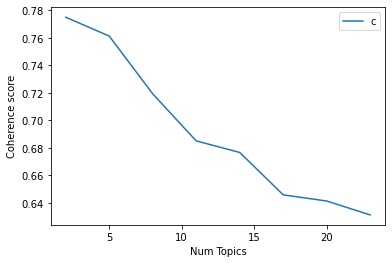

In [56]:
# Show graph
limit=24; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topic =", m, " has Coherence Value of", round(cv, 4))

Num Topic = 2  has Coherence Value of 0.775
Num Topic = 5  has Coherence Value of 0.7613
Num Topic = 8  has Coherence Value of 0.7193
Num Topic = 11  has Coherence Value of 0.6851
Num Topic = 14  has Coherence Value of 0.6768
Num Topic = 17  has Coherence Value of 0.6459
Num Topic = 20  has Coherence Value of 0.6414
Num Topic = 23  has Coherence Value of 0.6313


In [58]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.049*"goal" + 0.049*"rape" + 0.049*"idea" + 0.024*"lol" + 0.024*"bruh" + '
  '0.024*"murder" + 0.024*"word" + 0.024*"bitch" + 0.024*"twat" + '
  '0.024*"life"'),
 (1,
  '0.064*"feminism" + 0.064*"answer" + 0.043*"feminist" + 0.043*"sexist" + '
  '0.043*"write" + 0.021*"sound" + 0.021*"sigh" + 0.021*"eu" + 0.021*"remind" '
  '+ 0.021*"aim"')]


In [59]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...","RT Call me sexist, but when I go to an auto pl..."
1,1,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...","Wrong, ISIS follows the example of Mohammed an..."
2,2,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...",RT nooo not sexist but most women are bad drivers
3,3,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...",RT Theres something wrong when a girl wins Way...
4,4,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...",A good Muslim is good despite his bad religion...
5,5,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...","Yeah, its called caring about human life, idio..."
6,6,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...",RT Literally on this site today😂
7,7,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...","According to Holly from Geordie Shore, ""Sassy ..."
8,8,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...",Aww I was looking forward to Ash and Camilla b...
9,9,0.0,0.5,"goal, rape, idea, lol, bruh, murder, word, bit...",You are a Muslim. You are brain dead. You repe...


In [60]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5098,"goal, rape, idea, lol, bruh, murder, word, bit...",...who is arguing that?
1,1.0,0.5098,"feminism, answer, feminist, sexist, write, sou...",Not legally.


In [61]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
print(topic_counts)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

0.0    5301
1.0      46
Name: Dominant_Topic, dtype: int64


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",5301.0,0.9914
1.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",46.0,0.0086
2.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
3.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
4.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
...,...,...,...,...
5342.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
5343.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
5344.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
5345.0,0.0,"goal, rape, idea, lol, bruh, murder, word, bit...",NaN,NaN
